In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
#loading all relevant libraries/packages
!git clone https://github.com/RizwanMunawar/yolov7-pose-estimation.git
!git clone https://github.com/WongKinYiu/yolov7.git

Cloning into 'yolov7-pose-estimation'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 200 (delta 44), reused 32 (delta 32), pack-reused 138 (from 1)
Receiving objects: 100% (200/200), 3.75 MiB | 19.31 MiB/s, done.
Resolving deltas: 100% (85/85), done.
Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Total 1197 (delta 0), reused 0 (delta 0), pack-reused 1197 (from 1)
Receiving objects: 100% (1197/1197), 74.23 MiB | 42.04 MiB/s, done.
Resolving deltas: 100% (519/519), done.


In [3]:
import os
import sys
sys.path.append('/content/yolov7')
#!pip install -r yolov7-pose-estimation/requirements.txt
#!pip install -r /content/yolov7/requirements.txt
import matplotlib.pyplot as plt
import torch
import cv2
from torchvision import transforms
import numpy as np
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts
from google.colab import drive
import csv

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weigths = torch.load('/content/gdrive/MyDrive/CompVision/yolov7-w6-pose.pt', map_location=device)
model = weigths['model']
_ = model.float().eval()

if torch.cuda.is_available():
    model.half().to(device)

<ipython-input-4-68feb000e4c7>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weigths = torch.load('/content/gdrive/MyDrive/CompVision/yolov7-w6-pose.pt', map_location=dev

In [5]:
#video_path = '/content/gdrive/MyDrive/CompVision/Swim_InputVideo.mp4' # Replace with your video's path in Google Drive
video_path = '/content/gdrive/MyDrive/CompVision/classificationvideos/BR.mp4' # Replace with your video's path in Google Drive

frame_Interval = 30

In [6]:
# Folder to save the frames
output_folder = '/content/gdrive/MyDrive/CompVision/BR_frames/'

# Open the video file using OpenCV
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"Frames Per Second (FPS): {fps}")
# Check if the video was opened correctly
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    frame_number = 0
    frame_saved = 0

    while True:
        # Read a frame from the video
        ret, frame = cap.read()

        # If there are no more frames, exit the loop
        if not ret:
            break


        if frame_number % frame_Interval == 0:
            # Define the frame filename
            frame_filename = os.path.join(output_folder, f'frame{frame_number}.jpg')

            # Save the frame as a JPEG image
            cv2.imwrite(frame_filename, frame)
            frame_saved += 1
            print(f'Saved: {frame_filename}')

        frame_number += 1

    print(f'Total frames saved: {frame_saved}')

# Release the video capture object
cap.release()

Frames Per Second (FPS): 30.0
Saved: /content/gdrive/MyDrive/CompVision/BR_frames/frame0.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_frames/frame30.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_frames/frame60.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_frames/frame90.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_frames/frame120.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_frames/frame150.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_frames/frame180.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_frames/frame210.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_frames/frame240.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_frames/frame270.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_frames/frame300.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_frames/frame330.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_frames/frame360.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_frames/frame390.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_frames/frame420.jpg


In [7]:
from pathlib import Path
import gc

# Define the joint names based on the model's keypoint output order
joint_names = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle"
]

# Indices for the grouped joints to label
# Indices for the joints to label (based on joint_names order)
joints_to_label = {
    "left_elbow": joint_names.index("left_elbow"),
    "right_elbow": joint_names.index("right_elbow"),
    "left_knee": joint_names.index("left_knee"),
    "right_knee": joint_names.index("right_knee"),
    "left_hip": joint_names.index("left_hip"),
    "right_hip": joint_names.index("right_hip"),
}

# Indices for the grouped joints to label
joint_groups = {
    "knees": [joint_names.index("left_knee"), joint_names.index("right_knee")],
    "hips": [joint_names.index("left_hip"), joint_names.index("right_hip")],
    "elbows": [joint_names.index("left_elbow"), joint_names.index("right_elbow")],
}


# Function to overlay grouped labels on the image
def plot_grouped_labels(image, keypoints, joint_groups, font_scale=0.5, font_color=(0, 255, 0), font_thickness=1):
    """
    Plots grouped joint labels on the image.
    :param image: The image to annotate.
    :param keypoints: The array of keypoints in the format [x1, y1, c1, x2, y2, c2, ...].
    :param joint_groups: A dictionary of group names and their corresponding joint indices.
    :param font_scale: Font scale for the text labels.
    :param font_color: Font color for the text labels (BGR format).
    :param font_thickness: Thickness of the font text.
    """
    for group_name, joint_indices in joint_groups.items():
        for joint_idx in joint_indices:
            x, y, confidence = keypoints[joint_idx * 3:joint_idx * 3 + 3]
            # Only label points with sufficient confidence
            if confidence > 0.4:

                cv2.putText(
                    image,
                    group_name,
                    (int(x), int(y) - 10),  # Offset label above the keypoint
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_scale,
                    font_color,
                    font_thickness,
                    lineType=cv2.LINE_AA
                )
            cv2.circle(image, (int(x), int(y)), radius=5, color=(0, 0, 255), thickness=-1)

    return image

In [8]:
# Function to process and save images with frame numbering
def process_and_save_images(input_folder, output_folder, model, device, csv_path):
    #drive.mount('/content/gdrive', force_remount=True)
    input_folder = Path(input_folder)
    output_folder = Path(output_folder)
    # Loop through each image in the input folder
    frame_index = 0  # Initialize frame number

    # Create the output CSV file and write headers if it doesn't exist
    if not Path(csv_path).exists():
        with open(csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            # Write the header: frame index and joint names
            header = ['frame_index']
            for joint_name in joint_names:
                header.extend([f"{joint_name}_x", f"{joint_name}_y", f"{joint_name}_conf"])
            writer.writerow(header)
    # List the input folder contents directly
    for image_filename in input_folder.glob("*.jpg"):
        # Read the image
        image = cv2.imread(str(image_filename))  # Convert Path object to string path
        # Apply letterbox resizing
        image = letterbox(image, 960, stride=64, auto=True)[0]
        # Copy image for processing
        image_ = image.copy()
        # Convert image to tensor
        image = transforms.ToTensor()(image)
        image = torch.tensor(np.array([image.numpy()]))
        if torch.cuda.is_available():
            image = image.half().to(device)
        # Get model output
        output, _ = model(image)
        # Perform non-max suppression on keypoints
        output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)
        # Convert output to keypoints
        with torch.no_grad():
            output = output_to_keypoint(output)
        # Prepare image for saving
        nimg = image[0].permute(1, 2, 0) * 255
        nimg = nimg.cpu().numpy().astype(np.uint8)
        nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)

        # Plot keypoints on the image
        for idx in range(output.shape[0]):
            plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)
        # Plot grouped labels on the image
        for idx in range(output.shape[0]):
            nimg = plot_grouped_labels(nimg, output[idx, 7:].T.flatten(), joint_groups)

        # Save the processed image with the frame number
        output_image_path = output_folder / f"frame_{frame_index}_processed.jpg"  # Output as Path object
        cv2.imwrite(str(output_image_path), cv2.cvtColor(nimg, cv2.COLOR_BGR2RGB)) # Convert to string path for cv2
        print(f"Saved: {output_image_path}")

        # Append joint data to CSV
        with open(csv_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            for idx in range(output.shape[0]):
                keypoints = output[idx, 7:].T.flatten()
                row = [frame_index] + list(keypoints)  # Frame index followed by keypoint data
                writer.writerow(row)

        frame_index += frame_Interval  # Increment frame index

        # Release GPU memory after processing each image
        del image, image_, output, nimg  # Delete tensors and arrays
        torch.cuda.empty_cache()  # Clear GPU memory
        gc.collect()  # Force garbage collection to release RAM

input_folder = '/content/gdrive/MyDrive/CompVision/BR_seg/'  # Folder with input images (segmented)
#input_folder = '/content/gdrive/MyDrive/CompVision/BR_seg/'
output_folder = '/content/gdrive/MyDrive/CompVision/BR_poseframes/'
csv_path = '/content/gdrive/MyDrive/CompVision/BR_poseframes/joint_coordinates.csv'
# Call the function to process and save images
process_and_save_images(input_folder, output_folder, model, device, csv_path)


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Saved: /content/gdrive/MyDrive/CompVision/BR_poseframes/frame_0_processed.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_poseframes/frame_30_processed.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_poseframes/frame_60_processed.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_poseframes/frame_90_processed.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_poseframes/frame_120_processed.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_poseframes/frame_150_processed.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_poseframes/frame_180_processed.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_poseframes/frame_210_processed.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_poseframes/frame_240_processed.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_poseframes/frame_270_processed.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_poseframes/frame_300_processed.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_poseframes/frame_330_processed.jpg
Saved: /content/gdrive/MyDrive/CompVision/BR_

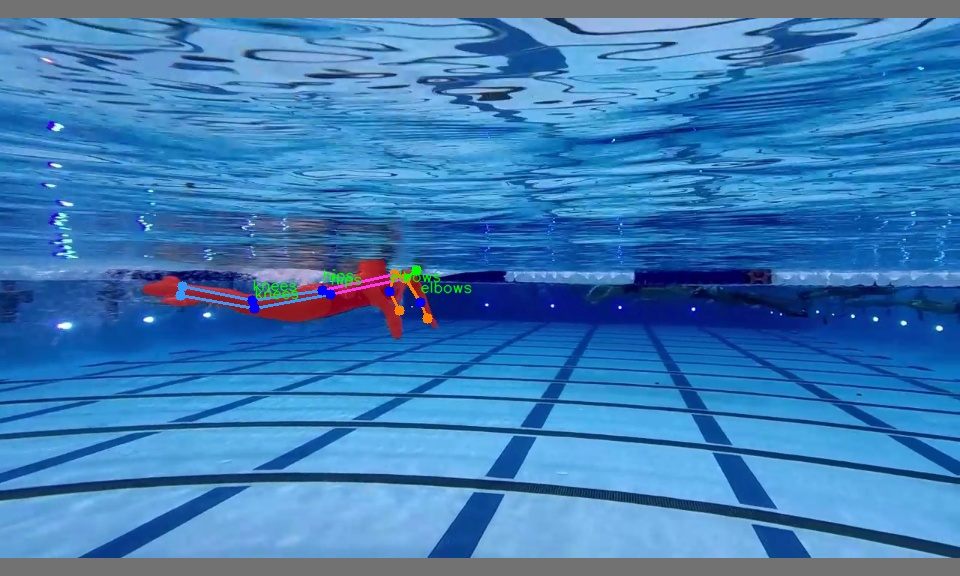

In [10]:
#segmented and pose estimated frames stored in google folder segposeframes/BR_poseframes/BK_poseframes/FL_poseframes
from google.colab import drive
from IPython.display import Image, display
image_path = '/content/gdrive/MyDrive/CompVision/BR_poseframes/frame_90_processed.jpg'
# test to show within colab pose estimation is performed
display(Image(filename=image_path))


In [12]:
!pip install natsort


In [13]:
import cv2
import os
from pathlib import Path
from natsort import natsorted  # For natural sorting of filenames

def images_to_video(input_folder, output_video_path, fps=2):
    """
    Convert images to a video.

    Args:
        input_folder (str): Path to the folder containing images.
        output_video_path (str): Path to save the output video.
        fps (int): Frames per second for the output video.
    """
    # Get list of image files sorted by natural order (e.g., frame_0, frame_1)
    input_folder = Path(input_folder)
    image_files = natsorted([str(file) for file in input_folder.glob("frame_*_processed.jpg")])
    #image_files = natsorted([str(file) for file in input_folder.glob("segmentedframe*.jpg")])

    if not image_files:
        print("No images found in the input folder!")
        return

    # Read the first image to get dimensions
    first_frame = cv2.imread(image_files[0])
    height, width, _ = first_frame.shape

    # Initialize the VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Write each image to the video
    for image_file in image_files:
        frame = cv2.imread(image_file)
        if frame is None:
            print(f"Skipping {image_file} (not a valid image)")
            continue
        video_writer.write(frame)

    # Release the video writer
    video_writer.release()
    print(f"Video saved to {output_video_path}")

# Paths
input_folder = '/content/gdrive/MyDrive/CompVision/BR_poseframes/'

# Change to your folder containing images
#output_video_path = "/content/gdrive/MyDrive/CompVision/firstoutput_pose_video.mp4"  # Change to your desired output path
output_video_path = "/content/gdrive/MyDrive/CompVision/BR_poseframes/with_seg_output_pose_video.mp4"  # Change to your desired output path

# Create video
images_to_video(input_folder, output_video_path)




Video saved to /content/gdrive/MyDrive/CompVision/BR_poseframes/with_seg_output_pose_video.mp4
